In [25]:
import requests
from datetime import datetime
import os
from datetime import timedelta
from datetime import time
import pandas as pd
import pytz
from urllib.error import HTTPError
import matplotlib.pyplot as plt
import urllib

# FIX DATA INTEGRITY


# WORK AS VALID TIME GMT BEING THE INDEX!

In [26]:
def create_specific_link(year, month, day):
    """Generates a URL for a specific date."""
    return f"https://api.weather.com/v1/location/SBGL:9:BR/observations/historical.json?apiKey=e1f10a1e78da46f5b10a1e78da96f525&units=e&startDate={year}{month:02d}{day:02d}&endDate={year}{month:02d}{day:02d}"

def fetch_last_line(file_path):
    """Fetches the last line from the URL file."""
    with open(file_path, 'r') as file:
        lines = file.readlines()
        file.close()
        return lines[-1].strip() if lines else None

def extract_date_from_url(url):
    """Extracts the date from the URL."""
    start_date_str = url.split('startDate=')[-1]
    year = int(start_date_str[:4])
    month = int(start_date_str[4:6])
    day = int(start_date_str[6:8])
    return year, month, day

def generate_urls(start_date, end_date):
    """Generates a list of urls from start_date to end_date."""
    url_list = []
    current_date = start_date

    while current_date <= end_date:
        url_list.append(create_specific_link(current_date.year, current_date.month, current_date.day))
        current_date += timedelta(days=1)

    return url_list

def update_url_file(file_path,update_path):

    open(update_path,'a').close()
    # Check if the file exists, if not, create it
    if not os.path.exists(file_path):
        with open(file_path, 'w') as file:
            pass
    if not os.path.exists(update_path):
        with open(update_path, 'w') as update_file:
            pass
    # Check if the file is empty
    if os.path.getsize(file_path) > 0:
        last_line = fetch_last_line(file_path)
        if last_line:
            year, month, day = extract_date_from_url(last_line)
            last_date = datetime(year, month, day)
        else:
            last_date = datetime(year=1999, month=1, day=1) #default if empty
    else:
        last_date = datetime(year=year, month=month, day=day)  #default if empty

    # Define the current date
    today = datetime.today()
    current_time = datetime.now().time()
    time_tuple = (datetime.now().date().year,datetime.now().date().month,datetime.now().date().day)

    #midnight = datetime.time(datetime(1, 1, 1, 0, 0, 0))
    midnight = time(0,0,0)
    # Generate URLs from the day after the last date up to today
    start_date = last_date + timedelta(days=1)
    urls_to_append = generate_urls(start_date-timedelta(days=1), today)

    # Append URLs to the file
    if len(urls_to_append) == 1:
        print("File is up-to-date! No additions required.")
    else:
        with open(file_path, 'a') as file:
            with open(update_path,'a') as update_file:
                #getting last date, to ensure complete data
                #retrieval
                update_file.write(urls_to_append[0]+'\n')
                for url in urls_to_append[1:]:
                    print(extract_date_from_url(url))
                    print(time_tuple)
                    if extract_date_from_url(url) == time_tuple:
                        if current_time == midnight:
                            #check if midnight, only append date if it is midnight
                            #else, always keep updating
                            #the action of not writing the url in api file
                            #implies not finishing the update for a day.
                            file.write('\n'+ url)
                        else:
                            update_file.write('\n'+url+'\n')

                    else:
                        if fetch_last_line(update_path) != url:
                            if url == urls_to_append[1]:
                                file.write('\n'+ url + '\n')
                                update_file.write('\n' + url+'\n')

                            else:
                                file.write(url + '\n')
                            update_file.write('\n'+url+'\n')
                        year,month,day = extract_date_from_url(url)
                        print(f"Appended: {year}-{month}-{day} URL of API")
                file.close()
                update_file.close()
def get_response_df(api_url):
    response = requests.get(api_url)
    data = response.json()
    data = data['observations']

    df = pd.DataFrame(data)
    return df
def convert_to_brasilia_time(timestamp):
    brasilia_timezone = pytz.timezone('America/Sao_Paulo')
    utc_dt = datetime.utcfromtimestamp(timestamp)
    brasilia_dt = utc_dt.replace(tzinfo=pytz.utc).astimezone(brasilia_timezone)
    return brasilia_dt.strftime('%Y-%m-%d %H:%M')

def update_dataframe(update_path, log_path):
    df_old = pd.DataFrame()
    date_history = []
    # Open files using context managers
    with open(update_path, 'r') as update_file, open(log_path, 'a') as log_file:
        if os.path.getsize(update_path) > 0:
            urls = update_file.read().splitlines()
            
            for line in urls:
                if line.strip():  # Check for non-empty line
                    try:
                        url_date = extract_date_from_url(line)
                        if (not(url_date in date_history)):      

                            proxies = urllib.request.getproxies()
                            headers = {
                                "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
                            }
                            response = requests.get(line, headers=headers, verify=True, timeout=10)
                            response.raise_for_status()
                            data = response.json()

                            if 'observations' in data:
                                df = pd.DataFrame(data['observations'])
                                df['valid_time_gmt'] = df['valid_time_gmt'].apply(convert_to_brasilia_time)
                                
                                # Append new rows to df_old
                                df_old = pd.concat([df_old, df], ignore_index=True)
                                
                                print(f"Fetching: {df['valid_time_gmt'].values[0]} data")
                        date_history.append(url_date)
                    except HTTPError:
                        print("API ERROR! Try again Later")
                    except requests.exceptions.RequestException as e:
                        error_msg = str(e)
                        log_file.write(f"\n{line} -> {error_msg}")
                        print(f"Skipping: {line} -> {error_msg}")
                    except KeyError as e:
                        error_msg = f"The response does not contain valid data: {str(e)}"
                        log_file.write(f"\n{line} -> {error_msg}")
                        print(f"Skipping: {line} -> {error_msg}")
    update_file.close()
    with open(update_path, 'w') as file: 
        file.close()


    return df_old.drop_duplicates(subset='valid_time_gmt', keep='last')
file_path = "Data/api.txt"
update_path = "Data/update_api.txt"
log_path = "Data/logs.txt"
df_path = "Data/SBGL_Weather_Data.csv"
df_old = pd.read_csv(df_path)
update_url_file(file_path,update_path)
update_patch_df= update_dataframe(update_path,log_path)
df_updated = pd.concat([df_old,update_patch_df],ignore_index=True,join='outer')

(2024, 8, 11)
(2024, 8, 11)
Fetching: 2024-08-10 00:00 data
Fetching: 2024-08-11 00:00 data


In [27]:
df_old = pd.read_csv(df_path)
df_old.columns

Index(['valid_time_gmt', 'day_ind', 'temp', 'icon_extd', 'wx_phrase', 'dewPt',
       'heat_index', 'rh', 'pressure', 'vis', 'wc', 'wdir', 'wdir_cardinal',
       'wspd', 'feels_like', 'uv_index'],
      dtype='object')

In [28]:
df_updated = pd.concat([df_old,update_patch_df],ignore_index=True,join='outer')

In [29]:
df_updated.valid_time_gmt.tail(400).values

array(['2024-07-28 15:00', '2024-07-28 16:00', '2024-07-28 17:00',
       '2024-07-28 18:00', '2024-07-28 19:00', '2024-07-28 20:00',
       '2024-07-28 21:00', '2024-07-28 22:00', '2024-07-28 23:00',
       '2024-07-29 00:00', '2024-07-29 01:00', '2024-07-29 02:00',
       '2024-07-29 03:00', '2024-07-29 04:00', '2024-07-29 05:00',
       '2024-07-29 06:00', '2024-07-29 06:24', '2024-07-29 07:00',
       '2024-07-29 08:00', '2024-07-29 09:00', '2024-07-29 10:00',
       '2024-07-29 11:00', '2024-07-29 12:00', '2024-07-29 13:00',
       '2024-07-29 14:00', '2024-07-29 15:00', '2024-07-29 16:00',
       '2024-07-29 17:00', '2024-07-29 18:00', '2024-07-29 18:35',
       '2024-07-29 19:00', '2024-07-29 20:00', '2024-07-29 21:00',
       '2024-07-29 22:00', '2024-07-29 23:00', '2024-07-30 00:00',
       '2024-07-30 01:00', '2024-07-30 02:00', '2024-07-30 03:00',
       '2024-07-30 04:00', '2024-07-30 05:00', '2024-07-30 06:00',
       '2024-07-30 07:00', '2024-07-30 08:00', '2024-07-30 09:

In [30]:
df_updated[['temp','valid_time_gmt']].tail(48)

,temp,valid_time_gmt
237944,66.0,2024-08-11 20:00
237945,70.0,2024-08-10 00:00
237946,70.0,2024-08-10 00:16
237947,70.0,2024-08-10 01:00
237948,70.0,2024-08-10 02:00
237949,68.0,2024-08-10 03:00
237950,68.0,2024-08-10 04:00
237951,66.0,2024-08-10 05:00
237952,66.0,2024-08-10 06:00
237953,64.0,2024-08-10 06:25


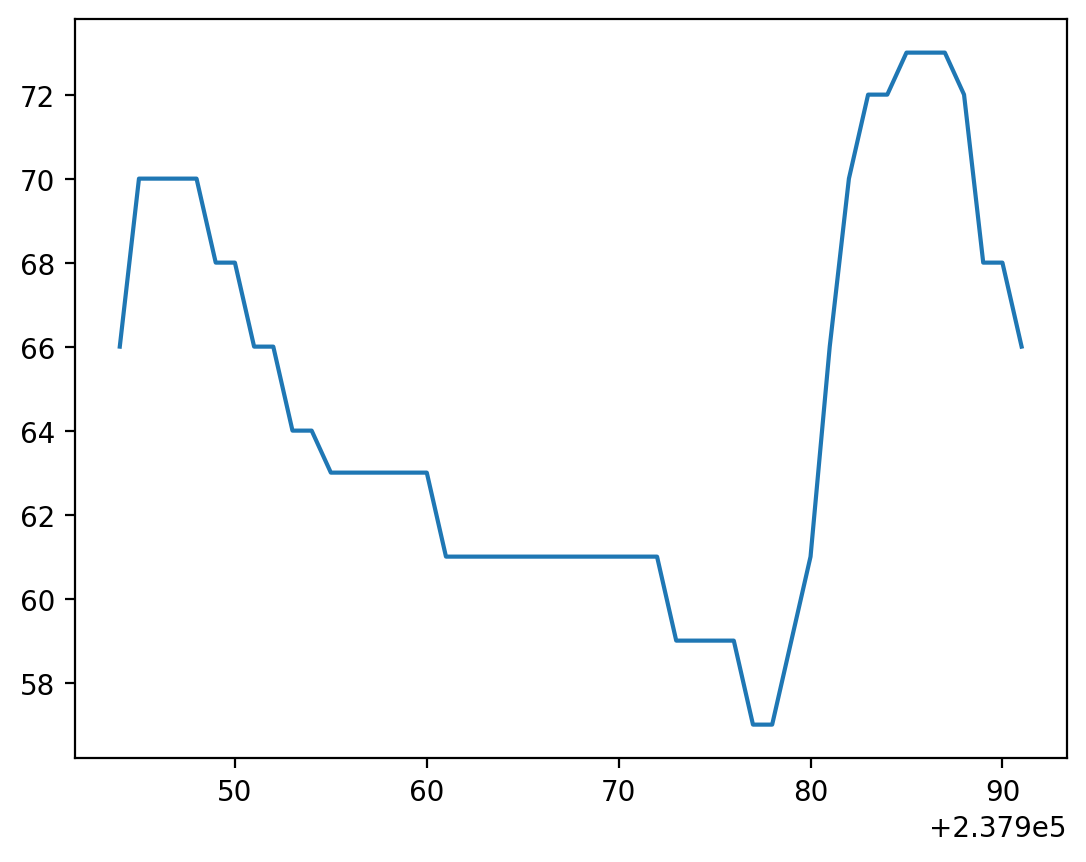

In [31]:
plt.figure(dpi=200)
plt.plot(df_updated['temp'].reset_index(drop=True).tail(48));

In [32]:
df_updated.tail(300)

,valid_time_gmt,day_ind,temp,icon_extd,wx_phrase,dewPt,heat_index,rh,pressure,vis,...,clds,water_temp,primary_wave_period,primary_wave_height,primary_swell_period,primary_swell_height,primary_swell_direction,secondary_swell_period,secondary_swell_height,secondary_swell_direction
237692,2024-08-01 15:00,D,79.0,3400,Fair,63.0,80.0,57.0,30.16,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
237693,2024-08-01 16:00,D,77.0,3400,Fair,61.0,79.0,57.0,30.16,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
237694,2024-08-01 17:00,D,75.0,3400,Fair,61.0,75.0,61.0,30.16,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
237695,2024-08-01 18:00,N,73.0,3300,Fair,61.0,73.0,65.0,30.19,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
237696,2024-08-01 19:00,N,73.0,3300,Fair,57.0,73.0,57.0,30.19,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237987,2024-08-11 16:00,D,73.0,3400,Fair,54.0,73.0,50.0,29.95,6.0,...,CLR,None,None,None,None,None,None,None,None,None
237988,2024-08-11 17:00,D,72.0,3400,Fair,54.0,72.0,53.0,29.95,6.0,...,CLR,None,None,None,None,None,None,None,None,None
237989,2024-08-11 18:00,N,68.0,3300,Fair,57.0,68.0,68.0,29.98,6.0,...,CLR,None,None,None,None,None,None,None,None,None
237990,2024-08-11 19:00,N,68.0,3300,Fair,57.0,68.0,68.0,29.98,6.0,...,CLR,None,None,None,None,None,None,None,None,None


In [33]:
df = df_updated.copy()
df = df[['valid_time_gmt', 'day_ind', 'temp', 'icon_extd', 'wx_phrase', 'dewPt',
       'heat_index', 'rh', 'pressure', 'vis', 'wc', 'wdir', 'wdir_cardinal',
       'wspd', 'feels_like', 'uv_index']]
df = df.ffill()
df.tail(5)

,valid_time_gmt,day_ind,temp,icon_extd,wx_phrase,dewPt,heat_index,rh,pressure,vis,wc,wdir,wdir_cardinal,wspd,feels_like,uv_index
237987,2024-08-11 16:00,D,73.0,3400,Fair,54.0,73.0,50.0,29.95,6.0,73.0,70.0,ENE,7.0,73.0,1.0
237988,2024-08-11 17:00,D,72.0,3400,Fair,54.0,72.0,53.0,29.95,6.0,72.0,40.0,NE,5.0,72.0,0.0
237989,2024-08-11 18:00,N,68.0,3300,Fair,57.0,68.0,68.0,29.98,6.0,68.0,130.0,SE,8.0,68.0,0.0
237990,2024-08-11 19:00,N,68.0,3300,Fair,57.0,68.0,68.0,29.98,6.0,68.0,140.0,SE,9.0,68.0,0.0
237991,2024-08-11 20:00,N,66.0,3300,Fair,59.0,66.0,78.0,30.01,6.0,66.0,140.0,SE,8.0,66.0,0.0


In [34]:
df = df.drop_duplicates(subset='valid_time_gmt', keep='last')

In [35]:
df.to_csv(df_path,index=False)